In [1]:
!git clone https://github.com/filipradenovic/revisitop.git
%cd revisitop/python
!python example_process_images.py

/var/lib/oar/.batch_job_bashrc: line 5: /home/alcontreras/.bashrc: No such file or directory
Cloning into 'revisitop'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 193 (delta 4), reused 3 (delta 0), pack-reused 172
Receiving objects: 100% (193/193), 43.81 KiB | 815.00 KiB/s, done.
Resolving deltas: 100% (87/87), done.
/home/alcontreras/revisitop/python
/var/lib/oar/.batch_job_bashrc: line 5: /home/alcontreras/.bashrc: No such file or directory
>> Dataset roxford5k directory does not exist. Creating: /home/alcontreras/revisitop/data/datasets/roxford5k/jpg
>> Downloading dataset roxford5k archive oxbuild_images-v1.tgz...
--2023-12-13 21:23:42--  https://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images-v1.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sen

### Librerias

In [392]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer


from scipy.io import loadmat
from revisitop.python.evaluate import compute_map, compute_ap


### Pre-procesamiento

In [60]:
import numpy as np
import cv2
class RootSIFT:
	def __init__(self):
		# initialize the SIFT feature extractor
		self.extractor =  cv2.SIFT_create()
	def compute(self, image, kps, eps=1e-7):
		# compute SIFT descriptors
		(kps, descs) = self.extractor.compute(image, kps)
		# if there are no keypoints or descriptors, return an empty tuple
		if len(kps) == 0:
			return ([], None)
		# apply the Hellinger kernel by first L1-normalizing and taking the
		# square-root
		descs /= (descs.sum(axis=1, keepdims=True) + eps)
		descs = np.sqrt(descs)
		#descs /= (np.linalg.norm(descs, axis=1, ord=2) + eps)
		# return a tuple of the keypoints and descriptors
		return (kps, descs)

In [68]:
def compute_rootsift(data,folder_imgs,n_keypoint=1500, query=False):
    rs = RootSIFT()
    all_descriptors = []
    detector = cv2.xfeatures2d.SIFT_create(n_keypoint) 
    
    if query:
        image_names = data["qimlist"]
    else:
        image_names = data["imlist"]
    
    for i,name in enumerate(tqdm(image_names, desc="Calculando descriptores")):
        img_path = f"{folder_imgs}/{name}.jpg"
        img = Image.open(img_path)
        
        if query:
            crop_limits = data["gnd"][i]["bbx"]
            img = img.crop(crop_limits)
            
        gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        kps = detector.detect(gray)

        _, descs = rs.compute(gray,kps)
        
        if descs is not None:
            all_descriptors.append(descs)
        else:
            all_descriptors.append(np.zeros((1,128)))

    return all_descriptors

In [15]:
file = "revisitop/data/datasets/roxford5k/gnd_roxford5k.pkl"
folder_imgs = "revisitop/data/datasets/roxford5k/jpg"
with open(file, "rb") as f:
    data = pickle.load(f)

total = compute_rootsift(data, folder_imgs)

Calculando descriptores: 100%|██████████| 4993/4993 [19:35<00:00,  4.25it/s]


In [16]:
np.save("descrip_db.npy", np.array(total,dtype=object))

In [69]:
querys = compute_rootsift(data, folder_imgs, query=True)

Calculando descriptores: 100%|██████████| 70/70 [00:05<00:00, 11.88it/s]


In [71]:
np.save("descrip_querys.npy", np.array(querys,dtype=object))

### K-Means

In [72]:
sift_db =np.load("descrip_db.npy",allow_pickle=True)
sift_querys =np.load("descrip_querys.npy",allow_pickle=True)

concat_sift = np.vstack(sift_db)
concat_sift.shape

(6724349, 128)

In [ ]:
k_values = [3000,4000,5000,6000,7000]

# Almacena las inercias para cada número de clúster
inertias = []

# Calcula la inercia para cada número de clúster
for k in k_values:
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=65536, random_state=42,max_iter=10000, n_init="auto")
    kmeans.fit(concat_sift)
    inertias.append(kmeans.inertia_)

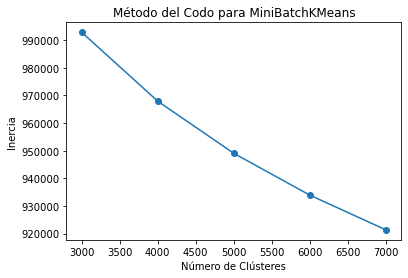

In [14]:
plt.plot(k_values, inertias, marker='o')
plt.title('Método del Codo para MiniBatchKMeans')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()

In [23]:
kmeans = MiniBatchKMeans(n_clusters=7000, batch_size=1024, random_state=42,max_iter=10000, n_init="auto")
kmeans.fit(concat_sift.astype(np.float32))

MiniBatchKMeans(max_iter=10000, n_clusters=7000, n_init='auto', random_state=42)

In [110]:
n_clusters = 7000

db_encoding = []
db_tf_encoding = []

for img_descriptors in tqdm(sift_db):
    pred = kmeans.predict(img_descriptors.astype(np.float32))
    enc = np.sum(np.eye(n_clusters)[pred], axis=0)
    db_encoding.append(enc)
    db_tf_encoding.append(enc/np.linalg.norm(enc))

db_encoding = np.vstack(db_encoding)
db_tf_encoding = np.vstack(db_tf_encoding)

np.save("db_bow.npy",db_encoding)
np.save("db_bow_tf.npy",db_tf_encoding)

100%|██████████| 4993/4993 [06:05<00:00, 13.65it/s]


In [111]:
querys_encoding = []
querys_tf_encoding = []

for img_descriptors in tqdm(sift_querys):
    pred = kmeans.predict(img_descriptors.astype(np.float32))
    enc = np.sum(np.eye(n_clusters)[pred], axis=0)
    querys_encoding.append(enc)
    querys_tf_encoding.append(enc/np.linalg.norm(enc))

querys_encoding = np.vstack(querys_encoding)
querys_tf_encoding = np.vstack(querys_tf_encoding)

np.save("querys_bow.npy",querys_encoding)
np.save("querys_tf_bow.npy",querys_tf_encoding)

100%|██████████| 70/70 [00:04<00:00, 14.46it/s]


In [53]:
#-------- TF-IDF --------#
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(db_encoding)

arr_tfidf = tfidf_matrix.toarray()

np.save("db_bow_tf_idf.npy", arr_tfidf)

In [78]:
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(querys_encoding)

arr_tfidf = tfidf_matrix.toarray()

np.save("querys_bow_tf_idf.npy", arr_tfidf)

### Evaluacion

In [112]:
db_bow = np.load("db_bow.npy")
querys_bow = np.load("querys_bow.npy")

In [113]:
db_tf= np.load("db_bow_tf.npy")
querys_tf = np.load("querys_tf_bow.npy")

In [114]:
db_tfidf = np.load("db_bow_tf_idf.npy")
querys_tfidf = np.load("querys_bow_tf_idf.npy")

In [458]:
def evaluate(db,querys, data):
    
    cosine_sim = cosine_similarity(db, querys)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]
    
    gnd = data['gnd']

    # evaluate ranks
    ks = [1,5,10]

    # search for easy
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['hard']])
        gnd_t.append(g)
    mapE, apsE, mprE, prsE = compute_map(ranks, gnd_t, ks)

    # search for easy & hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk']])
        gnd_t.append(g)
    mapM, apsM, mprM, prsM = compute_map(ranks, gnd_t, ks)

    # search for hard
    gnd_t = []
    for i in range(len(gnd)):
        g = {}
        g['ok'] = np.concatenate([gnd[i]['hard']])
        g['junk'] = np.concatenate([gnd[i]['junk'], gnd[i]['easy']])
        gnd_t.append(g)
    mapH, apsH, mprH, prsH = compute_map(ranks, gnd_t, ks)

    print('>> {}: mAP E: {}, M: {}, H: {}'.format("roxford5k", np.around(mapE*100, decimals=2), np.around(mapM*100, decimals=2), np.around(mapH*100, decimals=2)))

In [459]:
evaluate(db_bow,querys_bow, data)

>> roxford5k: mAP E: 20.77, M: 16.79, H: 5.57


In [460]:
evaluate(db_tf,querys_tf, data)

>> roxford5k: mAP E: 20.77, M: 16.79, H: 5.57


In [461]:
evaluate(db_tfidf,querys_tfidf, data)

>> roxford5k: mAP E: 19.91, M: 16.92, H: 6.81


In [399]:
def get_ap(db,query,data, dificultad="easy"):

    cosine_sim = cosine_similarity(db, query)
    ranks = np.argsort(cosine_sim, axis=0)[::-1]

    aps =[]

    gnd = data["gnd"]

    for i in range(70):
    
        if dificultad =="easy":
            target = gnd[i]["easy"]
        elif dificultad == "medium":
            target = np.concatenate([gnd[i]['easy'], gnd[i]['hard']])
        else:
            target = gnd[i]["hard"]
        
        #Vemos las posiciones donde se encuentran los ground truth
        ranks0= np.arange(ranks.shape[0])[np.in1d(ranks[:,i],target)]

        try:
            ap = compute_ap(ranks0, len(target))
        except:
            ap =0


        aps.append(ap)
    
    return np.array(aps)


In [452]:
def plot_mejor_peor(aps,data,ranks):
    
    mejor_pos, peor_pos = aps.argmax(), aps.argmin()
    
    query_mejor =Image.open("revisitop/data/datasets/roxford5k/jpg/"+data["qimlist"][mejor_pos]+".jpg")
    query_peor =Image.open("revisitop/data/datasets/roxford5k/jpg/"+data["qimlist"][peor_pos]+".jpg")
    
    pred_best = [Image.open("revisitop/data/datasets/roxford5k/jpg/"+data["imlist"][x]+".jpg") for x in ranks[:,mejor_pos][:5]]
    pred_peor = [Image.open("revisitop/data/datasets/roxford5k/jpg/"+data["imlist"][x]+".jpg") for x in ranks[:,peor_pos][:5]]

    bb_mejor = data["gnd"][mejor_pos]["bbx"]
    bb_peor = data["gnd"][peor_pos]["bbx"]

    
    #----------Mejor resultado----------#
    print(f"Mejor pos:{mejor_pos}")
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    ax[0].imshow(query_mejor)
    ax[0].axis('off')
    ax[0].set_title('Query')
    rect = patches.Rectangle((bb_mejor[0], bb_mejor[1]), bb_mejor[2]-bb_mejor[0], bb_mejor[3]-bb_mejor[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    for i in range(5):
        ax[i+1].imshow(pred_best[i])
        ax[i+1].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    
    #----------Peor resultado----------#
    print(f"Peor pos:{peor_pos}")
    fig, ax = plt.subplots(1, 6, figsize=(18, 3))

    ax[0].imshow(query_peor)
    ax[0].axis('off')
    ax[0].set_title('Query')
    rect = patches.Rectangle((bb_peor[0], bb_peor[1]), bb_peor[2]-bb_peor[0], bb_peor[3]-bb_peor[1],
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

    for i in range(5):
        ax[i+1].imshow(pred_peor[i])
        ax[i+1].axis('off')

    plt.tight_layout()
    plt.show()


In [453]:
cosine_sim = cosine_similarity(db_tf, querys_tf)
ranks = np.argsort(cosine_sim, axis=0)[::-1]

In [454]:
aps_easy = get_ap(db_tf, querys_tf, data, dificultad="easy")
aps_medium= get_ap(db_tf, querys_tf, data, dificultad="medium")
aps_hard= get_ap(db_tf, querys_tf, data, dificultad="hard")

Mejor pos:37


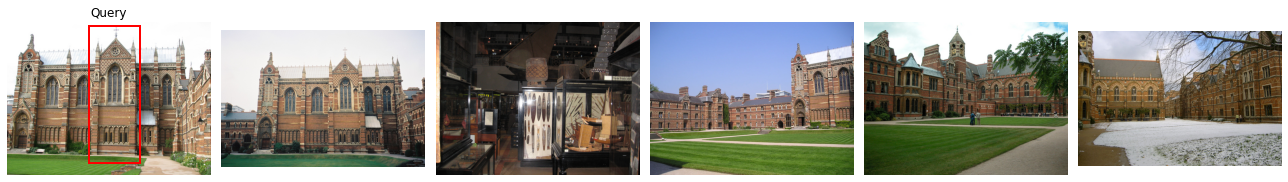

Peor pos:11


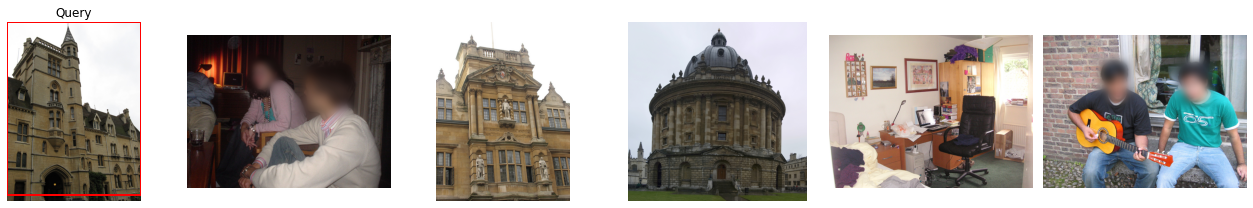

In [455]:
plot_mejor_peor(aps_easy, data, ranks)

Mejor pos:51


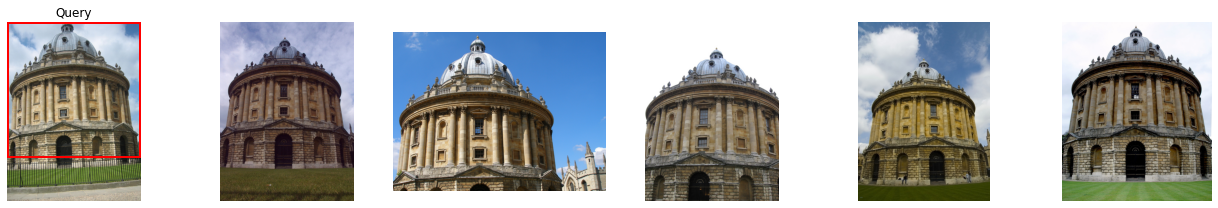

Peor pos:45


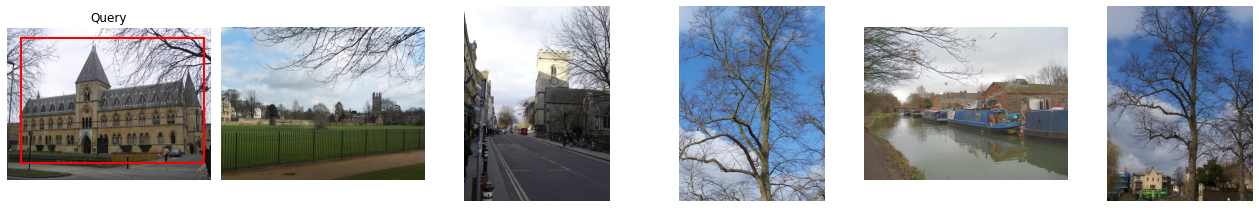

In [456]:
plot_mejor_peor(aps_medium, data, ranks)

Mejor pos:46


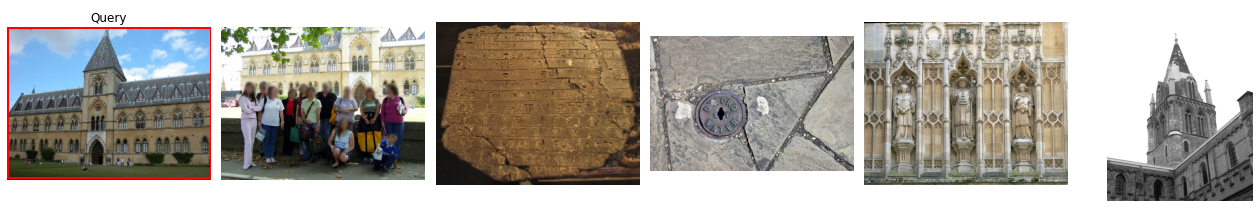

Peor pos:45


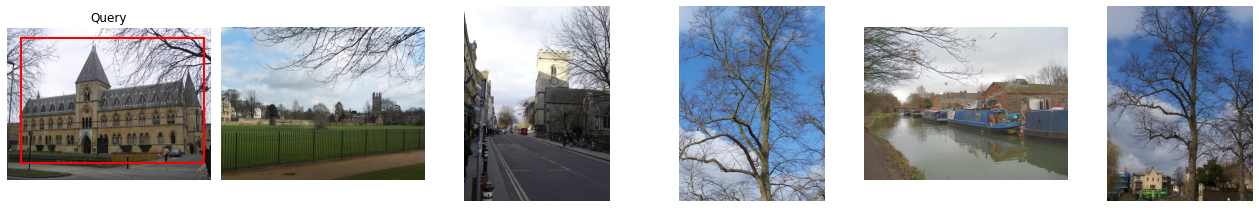

In [457]:
plot_mejor_peor(aps_hard, data, ranks)